In [ ]:
import os
import sys
import datetime as dt
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


: 

In [3]:
path = '..\\data\\raw'
merchant_df = pd.read_csv(f'{path}\\merchants.csv')
trans_df = pd.read_csv(f'{path}\\transactions.csv')
users_df = pd.read_csv(f'{path}\\users.csv')

In [4]:
merchant_df.head()

,merchant_id,category,city,avg_trans_amount,is_fraud_merchant
0,merch_0,Food,Surat,500,0
1,merch_1,Gaming,Bangalore,1500,0
2,merch_2,Fashion,Patna,800,0
3,merch_3,Services,Mumbai,3500,0
4,merch_4,Electronics,Jaipur,2200,0


In [5]:
merchant_df.shape

(100, 5)

In [6]:
merchant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   merchant_id        100 non-null    object
 1   category           100 non-null    object
 2   city               100 non-null    object
 3   avg_trans_amount   100 non-null    int64 
 4   is_fraud_merchant  100 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


In [7]:
trans_df.head()

,trans_id,user_id,merchant_id,device_id,amount,timestamp,is_fraud
0,t_0,user_357,merch_54,device_30,2982.73,2025-12-08T21:22:46.331002,0
1,t_1,user_174,merch_35,device_13,1851.59,2025-12-01T18:02:53.331462,0
2,t_2,user_79,merch_27,device_19,395.47,2025-11-30T17:00:04.331850,0
3,t_3,user_490,merch_97,device_56,1603.48,2025-12-04T19:11:00.332237,0
4,t_4,user_172,merch_13,device_228,1914.49,2025-11-17T19:36:46.332622,0


In [8]:
trans_df.shape

(2000, 7)

In [9]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trans_id     2000 non-null   object 
 1   user_id      2000 non-null   object 
 2   merchant_id  2000 non-null   object 
 3   device_id    2000 non-null   object 
 4   amount       2000 non-null   float64
 5   timestamp    2000 non-null   object 
 6   is_fraud     2000 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 109.5+ KB


In [10]:
users_df.head()

,user_id,age_bucket,state,user_risk_score
0,user_0,35-44,TN,0.110769
1,user_1,45-60,GJ,0.136280
2,user_2,18-24,KA,0.164581
3,user_3,35-44,MH,0.164677
4,user_4,35-44,UP,0.060519


In [11]:
users_df.shape

(500, 4)

In [12]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          500 non-null    object 
 1   age_bucket       500 non-null    object 
 2   state            500 non-null    object 
 3   user_risk_score  500 non-null    float64
dtypes: float64(1), object(3)
memory usage: 15.8+ KB


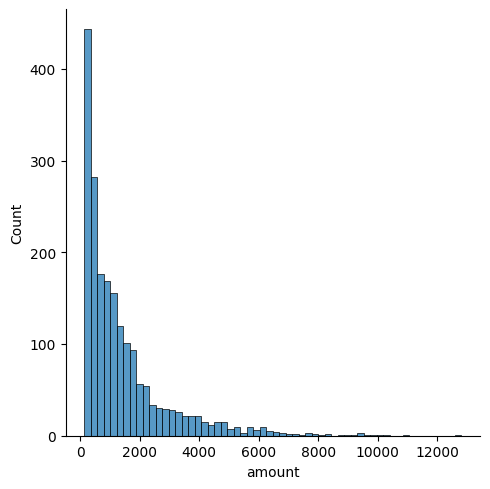

In [13]:
sns.displot(trans_df['amount'])

#### What I found

With this graph I found that small amount transactions are more and there are very few transactions with very high amount.

   merchant_id  count
68    merch_70    104
40    merch_45    102
39    merch_44    101
49    merch_53     95
82    merch_83     83
30    merch_36     26
83    merch_84     26
66    merch_69     23
52    merch_56     22
98    merch_98     22


<BarContainer object of 100 artists>

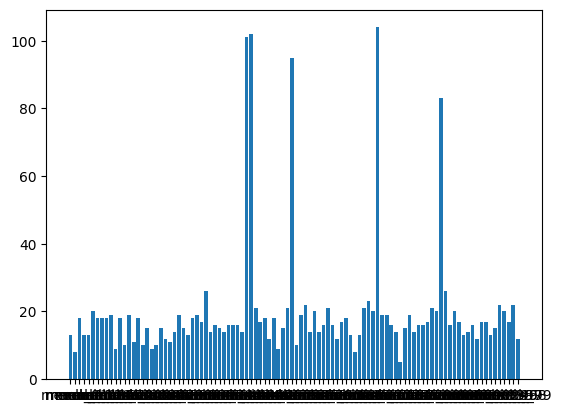

In [14]:
#Merchant activity
merch_activity_series = trans_df.groupby(['merchant_id']).size().reset_index(name='count')
print(merch_activity_series.sort_values(['count'],ascending=False).head(10))
plt.bar(merch_activity_series['merchant_id'],merch_activity_series['count'])

##### What I found
The merchant activity distribution is mostly uniform with ~20–30 transactions per merchant, but a small set of merchants show extremely high activity. These high-degree merchants will receive stronger neighborhood signals during message passing, leading to more confident embeddings. However, high activity alone does not indicate fraud; fraud must be inferred from behavioral patterns such as transaction size, timing, and shared users

###### Next Step

Now I'll create a dataframe with transactions and merchants which will have below columns and will try a model to predict the fraud merchant with the tabular data. If the model can predict the fraud merchant precisely then we do not need GNN.

1. merchant_id
2. total_transaction_count
3. avg_transaction_amount
4. std_transaction_amount
5. night_transaction_ratio
6. unique_user_count
7. category_encoded
8. city_encoded
9. is_fraud_merchant

In [15]:
temp_merchant_df = pd.DataFrame()

In [32]:
temp_merchant_df['merchant_id'] = merchant_df['merchant_id']
temp_merchant_df['category'] = merchant_df['category']
temp_merchant_df['city'] = merchant_df['city']

In [33]:
# total_transaction_count

temp_merchant_df['total_transaction_count'] = trans_df.groupby('merchant_id').size().reset_index(name='count')['count']

In [34]:
temp_merchant_df['avg_transaction_amount'] = trans_df.groupby('merchant_id')['amount'].agg(np.average).reset_index(name='average_amount')['average_amount']
temp_merchant_df

,merchant_id,total_transaction_count,avg_transaction_amount,std_transaction_amount,category,city
0,merch_0,13,479.767692,212.092617,Food,Surat
1,merch_1,8,1971.361250,864.222102,Gaming,Bangalore
2,merch_2,18,3629.294444,1012.116131,Fashion,Patna
3,merch_3,13,4005.842308,1354.494589,Services,Mumbai
4,merch_4,13,477.702308,208.751655,Electronics,Jaipur
...,...,...,...,...,...,...
95,merch_95,22,2614.477727,1015.408622,Electronics,Jaipur
96,merch_96,20,1660.873000,604.802873,Gaming,Bangalore
97,merch_97,17,3684.695882,1727.463161,Services,Vizag
98,merch_98,22,2260.683182,1075.040651,Electronics,Vizag


In [31]:
temp_merchant_df['std_transaction_amount'] = trans_df.groupby('merchant_id')['amount'].agg(np.std).reset_index(name='std_amount')['std_amount']
temp_merchant_df

C:\Users\DELL\AppData\Local\Temp\ipykernel_7652\2557883429.py:1: FutureWarning: The provided callable <function std at 0x00000141C55734C0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  temp_merchant_df['std_transaction_amount'] = trans_df.groupby('merchant_id')['amount'].agg(np.std).reset_index(name='std_amount')['std_amount']


,merchant_id,total_transaction_count,avg_transaction_amount,std_transaction_amount
0,merch_0,13,479.767692,212.092617
1,merch_1,8,1971.361250,864.222102
2,merch_2,18,3629.294444,1012.116131
3,merch_3,13,4005.842308,1354.494589
4,merch_4,13,477.702308,208.751655
...,...,...,...,...
95,merch_95,22,2614.477727,1015.408622
96,merch_96,20,1660.873000,604.802873
97,merch_97,17,3684.695882,1727.463161
98,merch_98,22,2260.683182,1075.040651


In [ ]:
# temp_df = trans_df[['merchant_id','timestamp','user_id']]
np.datetime64(temp_df['timestamp'])
# for row in temp_df:
#     if 4 <= row['timestamp'].dt.time.hour() >= 22 :
#         row['night_bias'] = 1
#     else:
#         row['nght_bias'] = 0

: 

In [88]:
# sample_users = users_df['user_id'].sample(20)
# sample_merchants = merchant_df['merchant_id'].sample(20)
sample_trans = trans_df.sample(20)
G = nx.Graph()



In [99]:
np.array(sample_trans['user_id'])

array(['user_490', 'user_22', 'user_15', 'user_52', 'user_140',
       'user_279', 'user_156', 'user_167', 'user_183', 'user_346',
       'user_293', 'user_43', 'user_41', 'user_343', 'user_127',
       'user_414', 'user_238', 'user_343', 'user_13', 'user_46'],
      dtype=object)

In [141]:
G.clear()
G.add_nodes_from(
    sample_trans['user_id'].unique(),
    node_type = 'user'
)
G.add_nodes_from(
    sample_trans['merchant_id'].unique(),
    node_type = 'merchant'
)

color_map = {
    'user': "skyblue",
    'merchant' : 'red'
}

node_colors = [
    color_map[G.nodes[n]['node_type']]
    for n in G.nodes
]

In [142]:
edge_weight = sample_trans.groupby(['user_id','merchant_id']).size().reset_index(name='weights')

for _,row in edge_weight.iterrows():
    G.add_edge(
        row['user_id'],
        row['merchant_id'],
        trans_count = row['weights']
    )

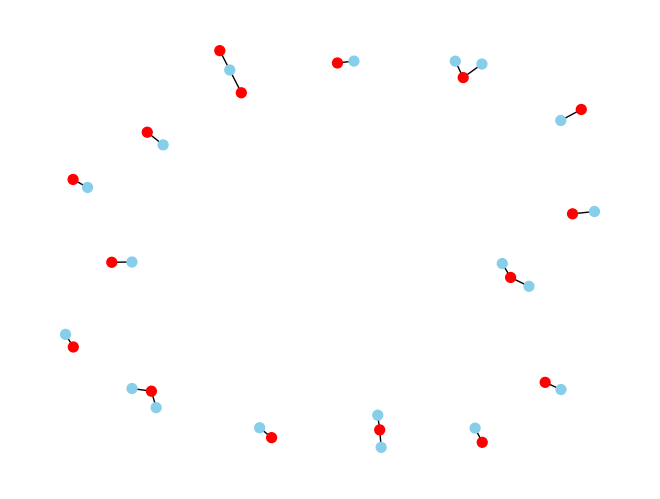

In [143]:

nx.draw(
    G,
    node_color=node_colors,
    with_labels=False,
    node_size=50
)

In [144]:
print(G.edges(data=True))

[('user_490', 'merch_31', {'trans_count': 1}), ('user_22', 'merch_0', {'trans_count': 1}), ('user_15', 'merch_83', {'trans_count': 1}), ('user_52', 'merch_45', {'trans_count': 1}), ('user_140', 'merch_83', {'trans_count': 1}), ('user_279', 'merch_45', {'trans_count': 1}), ('user_156', 'merch_84', {'trans_count': 1}), ('user_167', 'merch_27', {'trans_count': 1}), ('user_183', 'merch_7', {'trans_count': 1}), ('user_346', 'merch_53', {'trans_count': 1}), ('user_293', 'merch_29', {'trans_count': 1}), ('user_43', 'merch_93', {'trans_count': 1}), ('user_41', 'merch_5', {'trans_count': 1}), ('user_343', 'merch_54', {'trans_count': 1}), ('user_343', 'merch_89', {'trans_count': 1}), ('user_127', 'merch_24', {'trans_count': 1}), ('user_414', 'merch_87', {'trans_count': 1}), ('user_238', 'merch_53', {'trans_count': 1}), ('user_13', 'merch_39', {'trans_count': 1}), ('user_46', 'merch_84', {'trans_count': 1})]
